In [1]:
#!pip install sklearn_crfsuite
#!pip install eli5
# !pip install WordCloud

# Import necessary libraries

In [2]:
import json
import pandas as pd
import numpy as np
import sklearn
from pandas.core.groupby.base import OutputKey
from sklearn.feature_extraction import DictVectorizer
import sklearn_crfsuite
from sklearn_crfsuite import scorers, metrics
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
from tqdm import tqdm
import json
import eli5
import spacy
from spacy.training import offsets_to_biluo_tags
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
import csv
import re
from spacy.training import Example
from spacy.tokens import DocBin
from spacy.lang.en.stop_words import STOP_WORDS
from gensim.models.word2vec import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

from keras.optimizers import Adam

In [3]:
#load dataset
df_train = pd.read_csv("Final_dataset.csv")

In [4]:
test_data = [json.loads(line) for line in open('validation.json','r')]
test_data = pd.json_normalize(test_data)
test_data = test_data['Name']
test_data = test_data[:1000]

In [5]:
df_train.shape

(2393, 3)

In [6]:
#Only product titles are needed
df_train = df_train['Title']

In [7]:
df_train.head()

0                          Sterling Silver Angel Charm
1        HP Pavilion 23xi 58.40 cm (23ï¿½) IPS Monitor
2    East Carolina Pirates Ladies Personalized Bask...
3    Tekonsha 90195 P3 Electric Brake Control, 1-4 ...
4                    RN-XV WiFly Module - Wire Antenna
Name: Title, dtype: object

In [8]:
#nlp = spacy.load("en_core_web_lg")

In [9]:
#define custom functions to load, save and generate product and brand names list
def load_data(file):
    with open(file, "r", encoding = "utf-8")as f:
        data = json.load(f)
    return data

def save_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)
        
def generate_brand_products(file):
    chars = load_data(file)
    #print(len(hp_chars))
    #print(chars)
    new_characters = []
    for item in chars:
        new_characters.append(item.lower())
    return new_characters

In [10]:
brands = generate_brand_products("brand_names.json")

In [11]:
products = generate_brand_products("products.json")

In [12]:
print(brands)

['ruby reds', 'victorian', 'michigan state spartans', 'under armour', 'drake bulldogs', 'modernus', 'homedics', 'adidas', 'cleveland browns', 'harpa', 'guanabana', "nature's promise", 'chrysler', 'tech air', 'east carolina pirates', 'oase', 'troy', 'el gran', 'iowa state cyclones', 'reloj', 'northern illinois', 'bella', 'sellier & bellot', 'cammo', 'boston bruins', 'nike', 'eden', 'chevrolet', 'alterna', 'plyboo', 'anatolius', 'scientific anglers', 'alabama', 'purdue', 'maxtens', 'brand', 'sterling', 'hp', 'east carolina pirates', 'tekonsha', 'wifly', 'genairex', 'philadelphia eagles ', 'kansas city chiefs', 'goldwax', 'nittaku', 'oakland athletics', 'thule', 'creighton bluejays', 'seattle seahawks', 'vintage', 'arizona wildcats', 'miami hurricanes', 'kentucky wildcats', 'bo jackson', 'mariposa', 'alabama', 'multi-stripe', 'nike', 'dayton flyers', 'louisiana', 'michigan state', 'helena', 'grizzly straw', 'sam houston', 'seminoles', 'aggies', 'duke', 'colorblock', 'archie griffin', ' ho

In [13]:
print(products)

['locket', 'monitor', 'tshirt', 'display case', 'barwell fleet', 'plaque', 'hoodie', 'garden flag', 'dinning chair', 'hoodie', 'tshirt', 'football', 'sunglasses', 'ornament', 'money clip', 'flip flops', 'dress', 'hat', 'barrette', 'hats', 'photograph', 'tank top', 'soundtrack', 'socks', 'jersey', 'guillotine', 'pills', 'tote', 'sweatshirt', 'bags', 'sticker', 'barware', 'bulb kit', 'mold', 'polo', 'cubby', 'tstat', 'shirt', 'decal', 'cleats', 'gift set', 'scrub', 'dog dry', 'expedition pack', 'frame', 'pizelle maker', 'shuffler', 'eye cream', 'pineapple', 'brushguard', 'bowl', 'teakettle', 'lighter', 'map 2012', 'training', 'lid', 'jacket', 'hard disk', 'dog', 'flooring', 'tag', 'cape', 'diamonds', 'cleaner', 'shoes', 'powder', 'extension', 'tie', 'backpack', 'touring', 'riflescope', 'accessories', 'civic lx', 'netlimited', 'sign', 'skirt', 'repisa', 'marker', 'pad', 'slipper', 'card', 'sugar', 'overalls', 'tee', 'oak', 'pump', 'thermal halfzip', 'set', 'playlist', 'kit', 'necklace', '

# Spacy customization

In [14]:
#function to create input data for entity ruler
def create_training_data(file, entity_type):
    data = generate_brand_products(file)
    patterns = []
    for item in data:
        pattern = {
                    "label": entity_type,
                    "pattern": item
                  }
        patterns.append(pattern)
#     print(patterns)
    return patterns

In [15]:
patterns1 = create_training_data("brand_names.json", "BRAND")

In [16]:
patterns2 = create_training_data("products.json", "PRODUCT")

In [17]:
patterns1.extend(patterns2)

In [18]:
print(patterns1)

[{'label': 'BRAND', 'pattern': 'ruby reds'}, {'label': 'BRAND', 'pattern': 'victorian'}, {'label': 'BRAND', 'pattern': 'michigan state spartans'}, {'label': 'BRAND', 'pattern': 'under armour'}, {'label': 'BRAND', 'pattern': 'drake bulldogs'}, {'label': 'BRAND', 'pattern': 'modernus'}, {'label': 'BRAND', 'pattern': 'homedics'}, {'label': 'BRAND', 'pattern': 'adidas'}, {'label': 'BRAND', 'pattern': 'cleveland browns'}, {'label': 'BRAND', 'pattern': 'harpa'}, {'label': 'BRAND', 'pattern': 'guanabana'}, {'label': 'BRAND', 'pattern': "nature's promise"}, {'label': 'BRAND', 'pattern': 'chrysler'}, {'label': 'BRAND', 'pattern': 'tech air'}, {'label': 'BRAND', 'pattern': 'east carolina pirates'}, {'label': 'BRAND', 'pattern': 'oase'}, {'label': 'BRAND', 'pattern': 'troy'}, {'label': 'BRAND', 'pattern': 'el gran'}, {'label': 'BRAND', 'pattern': 'iowa state cyclones'}, {'label': 'BRAND', 'pattern': 'reloj'}, {'label': 'BRAND', 'pattern': 'northern illinois'}, {'label': 'BRAND', 'pattern': 'bella

In [19]:
#blank spacy English model with entity ruler in pipeline
def generate_spacy_rules(patterns):
    nlp = English()
    ruler = nlp.add_pipe("entity_ruler")
    ruler.add_patterns(patterns)
#     print(nlp.pipe_names)
    nlp.to_disk("prod_ner")

In [20]:
generate_spacy_rules(patterns1)

In [21]:
nlp = spacy.load("prod_ner")

In [22]:
#Function to format input data to required entity ruler format
def train_data_for_spacy(model, text):
    doc = nlp(text)
    results = []
    entities = []
    for ent in doc.ents:
        #print(ent.label_)
        entities.append((ent.start_char, ent.end_char, ent.label_))
    if len(entities) > 0:
        results = [text, {"entities": entities}]
        return (results)

In [23]:
#colors used in product titles listed
colors_list = load_data("colors.json")
colors = []
for item in colors_list:
    colors.append(item.lower())


In [24]:
a ='(23ã¯â¿â½)'
a.encode('ascii', 'ignore').decode()

'(23)'

# Spacy training

In [25]:
def get_spacy_train_data(input_data):
    nlp = spacy.load("prod_ner")
    DATA = []
    with open(input_data, "r", encoding='utf-8') as f:
        text = pd.read_csv(f)
#         print(text)
        df1 = list(text["Title"])
        data = []
        for item in df1:
            #print(item)
            data.append(item.lower())
        #print(data)
        for segment in data:
    #         print(segment)
            segment = segment.strip()
            segment = segment.replace("\n", " ")
            segment = segment.encode('ascii', 'ignore').decode()
            for i, word in enumerate(segment.split()):
    #             print(word)
                if word in STOP_WORDS:
    #                 print(word) 
                    segment = segment.replace(word, "")
    #                 print(segment)
                if word in colors:
                    segment = segment.replace(word, "")

            segment = re.sub(' +', ' ', segment)
    #         print(segment)
            punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''        
            for ele in segment:
                #print(ele)
                if ele in punc:
                    segment = segment.replace(ele, "")
                    segment = segment.strip()

    #         print(len(segment.split()))
            len1 = len(segment.split())
            for i, word in enumerate(segment.split()):
                if i < len1-1:
                    if (word + ' ' + segment.split()[i+1]) in colors:
                        segment = segment.replace(word + " " + segment.split()[i+1] + "", "") 
                        segment = segment.strip("  ")

            results = train_data_for_spacy(nlp, segment.strip())
            if results != None:
                    DATA.append(results)
    return DATA

In [26]:
TRAIN_DATA = get_spacy_train_data("Final_dataset.csv")

In [27]:
#Save the training data
save_data("training_data.json", TRAIN_DATA)

In [28]:
TRAIN_DATA[:5]

[['sterling angel charm',
  {'entities': [(0, 8, 'BRAND'), (15, 20, 'PRODUCT')]}],
 ['hp pavilion 23xi 5840 cm 23 ips monitor',
  {'entities': [(0, 2, 'BRAND'), (32, 39, 'PRODUCT')]}],
 ['east carolina pirates ladies personalized basketball long sleeve classic fit tshirt',
  {'entities': [(0, 21, 'BRAND'), (42, 52, 'PRODUCT'), (77, 83, 'PRODUCT')]}],
 ['tekonsha 90195 p3 electric brake control 14 trailer axles',
  {'entities': [(0, 8, 'BRAND'), (52, 57, 'PRODUCT')]}],
 ['rnxv wifly module  wire antenna', {'entities': [(5, 10, 'BRAND')]}]]

In [29]:
#convert entities to BIO tagged entities
def convert_to_bio_tags(data):
    nlp = spacy.load('en_core_web_lg')
    docs = []
    train_bio = []
    k = 0
    for text, annot in data:
        doc = nlp(text)
        tags = offsets_to_biluo_tags(doc, annot['entities'])
        bio_tags = [tag.replace('L-BRAND','I-BRAND').replace('U-BRAND','B-BRAND').replace('L-PRODUCT','I-PRODUCT').replace('U-PRODUCT','B-PRODUCT') for tag in tags]
        tokens = [tok.text for tok in doc]
        postags = [token.pos_ for token in doc]
        token_tags = list(zip(tokens,postags, bio_tags))
        train_bio_sample = [{'sentence_id':k,'words':el[0],'POS':el[1], 'labels':el[2]} for el in token_tags]
        #print(train_bio_sample)
        train_bio += train_bio_sample
        k += 1 
    return pd.DataFrame(train_bio,columns=['sentence_id','words','POS','labels'])

In [30]:
all_bio_df = convert_to_bio_tags(TRAIN_DATA)

In [31]:
all_bio_df.isnull().sum()

sentence_id    0
words          0
POS            0
labels         0
dtype: int64

In [32]:
all_bio_df.groupby('labels').size().reset_index(name='counts')

,labels,counts
0,B-BRAND,3096
1,B-PRODUCT,3094
2,I-BRAND,2071
3,I-PRODUCT,199
4,O,10387


In [33]:
y = all_bio_df.labels.values

classes = np.unique(y)
classes = classes.tolist()

new_classes = classes.copy()
new_classes.pop()
new_classes

['B-BRAND', 'B-PRODUCT', 'I-BRAND', 'I-PRODUCT']

In [40]:
#function to convert to required input format
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['words'].values.tolist(),
                                                           s['POS'].values.tolist(),
                                                           s['labels'].values.tolist())]
        self.grouped = self.data.groupby('sentence_id').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [41]:
getter = SentenceGetter(all_bio_df)
train_sent = getter.sentences

# EDA

In [34]:
entities_count = all_bio_df.groupby('labels').size().reset_index(name='counts')

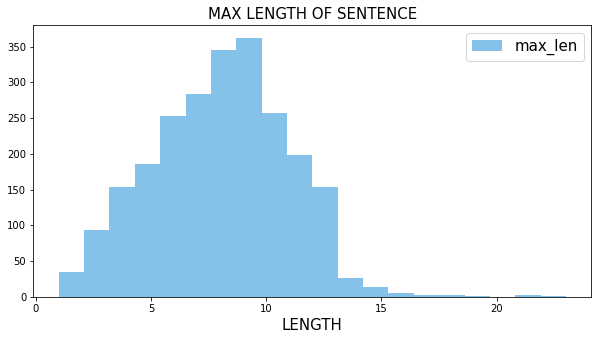

In [42]:
plt.figure(figsize = (10, 5))
plt.hist([len(s) for s in train_sent], color = '#85C1E9', label = 'max_len', bins = 20)
plt.title('MAX LENGTH OF SENTENCE',fontsize = 15)
plt.xlabel('LENGTH', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

In [43]:
text = " ".join(title for title in all_bio_df.words)
print ("There are {} words in the combination of all product titles.".format(len(text)))

There are 124931 words in the combination of all product titles.


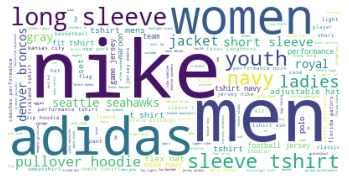

In [44]:
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [45]:
brands_dict = [] 
for text, annot in tqdm(TRAIN_DATA):
    ents = []
    for start, end, label in annot["entities"]:
        if label == "BRAND":
            brands_dict.append(text[start:end])

100%|██████████| 2371/2371 [00:00<00:00, 810620.70it/s]


In [46]:
brands = "+".join(item for item in brands_dict)
print ("There are {} words in the combination of all brand names.".format(len(brands)))

There are 37060 words in the combination of all brand names.


In [47]:
#supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

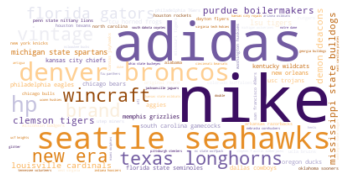

In [48]:
wordcloud = WordCloud(background_color="white", collocations=False, regexp= r"\w[\w' ]+", colormap='PuOr_r').generate(brands) #RdBu
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [49]:
products_dict = [] 
for text, annot in tqdm(TRAIN_DATA):
    ents = []
    for start, end, label in annot["entities"]:
        if label == "PRODUCT":
            if text[start:end] != 'black':
                products_dict.append(text[start:end])
            
products = "+".join(labels for labels in products_dict)
print ("There are {} words in the combination of all product names".format(len(products)))

100%|██████████| 2371/2371 [00:00<00:00, 406553.08it/s]

There are 21548 words in the combination of all product names


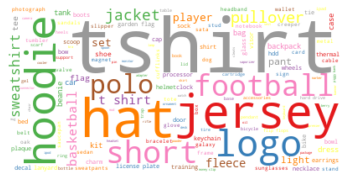

In [50]:
wordcloud = WordCloud(background_color="white", collocations=False, regexp= r"\w[\w' ]+", colormap='Set1_r').generate(products)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [51]:
nlp = spacy.load("prod_ner")
colors = {'BRAND': "#ff6961", "PRODUCT": "#85C1E9"}
options = {"ents": ['BRAND', 'PRODUCT'], "colors": colors}
for text in TRAIN_DATA[:10]:
    sent = text[0]
    spacy.displacy.render(nlp(sent), style='ent', options=options)

In [52]:
entities_count

,labels,counts
0,B-BRAND,3096
1,B-PRODUCT,3094
2,I-BRAND,2071
3,I-PRODUCT,199
4,O,10387


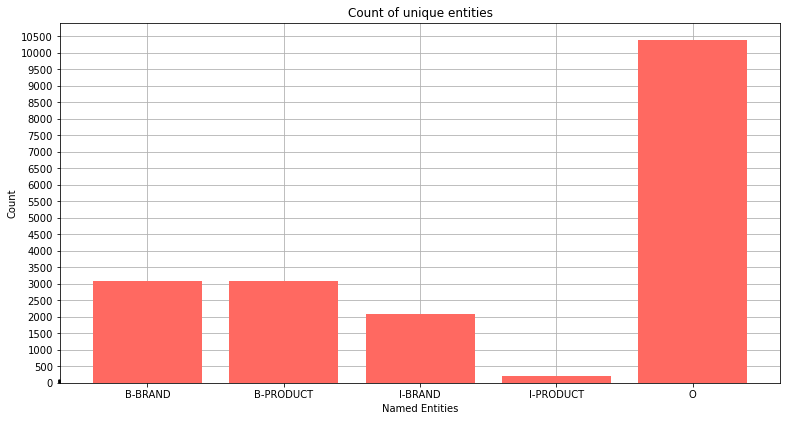

In [53]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
major_ticks = np.arange(0, 12000, 500)
minor_ticks = np.arange(0, 101, 5)


ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_axisbelow(True)
ax.bar(entities_count.labels, entities_count.counts, color = '#ff6961')
plt.xlabel("Named Entities")
plt.ylabel("Count")
plt.title("Count of unique entities")
plt.grid()
plt.show()


## Gensim Word2Vec with Neural Network

In [54]:
#import necessary libraries
from keras_preprocessing.sequence import pad_sequences
from gensim.models.word2vec import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from keras.utils import to_categorical
from keras.models  import Model
from tensorflow.keras.layers import Input, Dense,Embedding, Activation, Flatten

from tensorflow.keras import Sequential
import collections

In [55]:
word_vec = []
nlp = spacy.load("prod_ner")
with open("Final_dataset.csv", "r") as f:
    text = pd.read_csv(f)
    #print(text)
    df1 = list(text["ï»¿Title"])
    data = []
    for item in df1:
        #print(item)
        data.append(item.lower())
    #print(data)
    for segment in data:
#         print(segment)
        segment = segment.strip()
        segment = segment.replace("\n", " ")
        segment = segment.encode('ascii', 'ignore').decode()
        for i, word in enumerate(segment.split()):
#             print(word)
            if word in STOP_WORDS:
#                 print(word)
                segment = segment.replace(word, "")
        
        segment = re.sub(' +', ' ', segment)
#         print(segment)
        punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''        
        for ele in segment:
            #print(ele)
            if ele in punc:
                segment = segment.replace(ele, "")
                segment = segment.strip()
        
        dic = []
        for word in segment.split():
            dic.append(word)
        word_vec.append(dic)


In [56]:
# (word_vec)

In [57]:
save_data("train_data_01.json", word_vec)

In [58]:
w2v = Word2Vec(word_vec, vector_size=300, window=5, min_count=0, negative=10)

In [59]:
word_vectors = w2v.wv

In [60]:
word_vectors[0]

array([ 5.03403172e-02,  6.56134248e-01,  4.56202440e-02,  2.40771800e-01,
       -4.33438420e-02, -5.32442331e-01,  4.79035974e-01,  1.09822178e+00,
        2.60798752e-01, -2.40335185e-02, -4.90269847e-02, -6.45790994e-01,
        9.33388993e-02, -1.74755707e-01, -4.13643539e-01, -2.06955045e-01,
        1.83261037e-01, -2.20380276e-01,  1.59600243e-01, -2.76791245e-01,
       -4.45567995e-01,  1.93210602e-01,  2.57227302e-01,  2.10086644e-01,
        3.65383416e-01, -7.28277564e-02, -7.31126130e-01,  8.81500263e-03,
       -2.12032154e-01, -7.83140182e-01,  2.49015674e-01, -3.39242816e-01,
       -6.46502823e-02,  2.21434548e-01, -2.33255923e-01,  3.37903619e-01,
        5.26607692e-01, -2.98206449e-01,  1.10529870e-01, -1.22022569e-01,
       -1.89789951e-01,  1.84790120e-01,  1.05893053e-01, -2.16873154e-01,
        2.10018381e-01,  4.11251038e-01,  1.67613521e-01,  2.71889061e-01,
        2.64060162e-02,  5.82515657e-01,  1.35645345e-01,  5.04066534e-02,
       -2.28463471e-01, -

In [61]:
word_vectors.similar_by_word("nike")

[('mens', 0.999967098236084),
 ('adidas', 0.9999622702598572),
 ('blue', 0.9999614357948303),
 ('womens', 0.9999606013298035),
 ('black', 0.9999599456787109),
 ('red', 0.9999598264694214),
 ('x', 0.9999589920043945),
 ('ladies', 0.9999585747718811),
 ('youth', 0.9999579787254333),
 ('hp', 0.9999577403068542)]

In [62]:
all_bio_df = all_bio_df.loc[all_bio_df["words"] != ' ']

In [63]:
#function to convert to required input format
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['words'].values.tolist(),
                                                           s['POS'].values.tolist(),
                                                           s['labels'].values.tolist())]
        self.grouped = self.data.groupby('sentence_id').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [64]:
getter = SentenceGetter(all_bio_df)
train_sent = getter.sentences

In [65]:
train_sent[1]

[('hp', 'PROPN', 'B-BRAND'),
 ('pavilion', 'NOUN', 'O'),
 ('23xi', 'NOUN', 'O'),
 ('5840', 'NUM', 'O'),
 ('cm', 'NOUN', 'O'),
 ('23', 'NUM', 'O'),
 ('ips', 'NOUN', 'O'),
 ('monitor', 'NOUN', 'B-PRODUCT')]

In [66]:
test_data = pd.DataFrame(test_data)
test_data.rename(columns={'Name':'Title'}, inplace=True)

test_data.to_csv("test_data.csv")

TEST_DATA = get_spacy_train_data('test_data.csv')

In [67]:
test_df = convert_to_bio_tags(TEST_DATA)
test_df.head()

,sentence_id,words,POS,labels
0,0,ruby,NOUN,B-BRAND
1,0,reds,NOUN,I-BRAND
2,1,victorian,ADJ,B-BRAND
3,1,silver,PROPN,B-PRODUCT
4,1,masonic,ADJ,O


In [68]:
getter = SentenceGetter(test_df)
test_sent = getter.sentences

In [69]:
#function to fetch labels for each token
def get_tags(tagged_words):
    tag2id = {}
    for item in tagged_words:
        for tok in item:
#             print(tok[2])
            tag = tok[2]
            tag2id.setdefault(tag, len(tag2id))
    return tag2id

In [70]:
tag2id = get_tags(train_sent)

In [71]:
tag2id

{'B-BRAND': 0, 'O': 1, 'B-PRODUCT': 2, 'I-BRAND': 3, 'I-PRODUCT': 4}

In [72]:
# for k,i in word_vectors.key_to_index.items():
#     if k =='pavilion':
#         print(k)

In [73]:
word_vectors.key_to_index.items()

dict_items([('nike', 0), ('tshirt', 1), ('mens', 2), ('blue', 3), ('adidas', 4), ('black', 5), ('sleeve', 6), ('navy', 7), ('womens', 8), ('state', 9), ('performance', 10), ('jersey', 11), ('hat', 12), ('long', 13), ('hoodie', 14), ('logo', 15), ('red', 16), ('white', 17), ('youth', 18), ('ladies', 19), ('football', 20), ('polo', 21), ('pullover', 22), ('replica', 23), ('new', 24), ('jacket', 25), ('2014', 26), ('team', 27), ('green', 28), ('sideline', 29), ('orange', 30), ('royal', 31), ('arch', 32), ('adjustable', 33), ('game', 34), ('seattle', 35), ('zip', 36), ('fit', 37), ('short', 38), ('bulldogs', 39), ('shirt', 40), ('tigers', 41), ('broncos', 42), ('sweatshirt', 43), ('gray', 44), ('denver', 45), ('triblend', 46), ('seahawks', 47), ('x', 48), ('purple', 49), ('texas', 50), ('t', 51), ('kansas', 52), ('basketball', 53), ('crimson', 54), ('flex', 55), ('coaches', 56), ('classic', 57), ('carolina', 58), ('wildcats', 59), ('vneck', 60), ('fleece', 61), ('city', 62), ('maroon', 63)

In [74]:
#get word embedding for each word in the corpus
word2id = {k: v for k, v in word_vectors.key_to_index.items()}

In [75]:
#add 'UNK' to any new word in the vocabulary
def add_new_word(new_word, new_vector, new_index, embedding_matrix, word2id):
    embedding_matrix = np.insert(embedding_matrix, [new_index], [new_vector], axis=0)
    
    word2id = {word: (index+1) if index >= new_index else index
              for word, index in word2id.items()}
    word2id[new_word] = new_index
    return embedding_matrix, word2id

In [76]:
UNK_idx = 0
UNK_tok = 'UNK'

In [77]:
#define a word embedding for 'UNK'.
embedding_matrix = word_vectors.vectors
unk_vector = embedding_matrix.mean(0)
embedding_matrix, word2id = add_new_word(UNK_tok, unk_vector, UNK_idx,
                                        embedding_matrix, word2id)

In [78]:
def get_int_data(tagged_words, word2id, tag2id):
    X, y = [], []
    unk_count = 0
    
    for item in tagged_words:
        for word, pos, tag in item:
            y.append(tag2id.get(tag))
            if word in word2id:
                X.append(word2id.get(word))
            else:
                X.append(UNK_idx)
                unk_count +=1
#     print(f"% of unknown words: {unk_count/len(tagged_words)}")
    return (np.array(X), np.array(y))

In [79]:
X_train, y_train = get_int_data(train_sent, word2id, tag2id)
X_test, y_test = get_int_data(test_sent, word2id, tag2id)
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

In [80]:
#define NN model
hidden_size = 100
batch_size = 32

def define_model(embedding_matrix, class_count, activation):
    vocab_length = len(embedding_matrix)
    model =  Sequential()
    
    #layers that turns word indexes into vectors
    model.add(Embedding(input_dim=vocab_length,
                       output_dim=300,              #output of this layers is the word embedding of the input word
                       weights = [embedding_matrix],#matrix holding the trained embeddings
                       input_length=1))
    model.add(Flatten())
    model.add(Dense(hidden_size))
    model.add(Activation(activation))
    model.add(Dense(class_count))
    model.add(Activation('softmax'))
    
    opt = Adam(learning_rate=0.01)
    model.compile(optimizer=opt,
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])
    return model

In [81]:
idx2word = sorted(word2id, key=word2id.get)

In [82]:
#model evaluation function
def evaluate_model(model, idx2word, X_test, y_test):
    _, acc = model.evaluate(X_test, y_test)
    print("Accuracy: ", acc)
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    error_counter = collections.Counter()
    
    for i in range(len(X_test)):
        correct_tag_id = np.argmax(y_test[i])
        if y_pred_classes[i] != correct_tag_id:
            word = idx2word[X_test[i]]
            error_counter[word] +=1
    print("common errors: ", error_counter.most_common(5))

In [83]:
activations = ['relu', 'sigmoid', 'tanh']
for act in activations:
    print("\nActivation: ", act)
    prod_model = define_model(embedding_matrix, len(tag2id), act)
    prod_model.summary()
    prod_model.fit(X_train,
              y_train,
              batch_size=32,
              epochs = 3,
              verbose=1)
    print("\nStarting Evaluation")
    evaluate_model(prod_model, idx2word, X_test, y_test)


Activation:  relu
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 300)            1261800   
                                                                 
 flatten (Flatten)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 100)               30100     
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
 activation_1 (Activation)   (None, 5)                 0         
                                                                 
Total params: 1,292,405
Trainable par

In [391]:
# !pip install livelossplot

In [392]:
callbacks = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 1, mode = 'min', restore_best_weights = True)

In [84]:
#relu activation function
train_model = define_model(embedding_matrix, len(tag2id), 'relu')
print("\nTraining model on train data\n")
history_train = train_model.fit(X_train,
              y_train,
              batch_size=32,
              epochs = 5,
              verbose=1)


Training model on train data

Epoch 1/5
576/576 [==============================] - 5s 8ms/step - loss: 0.4302 - accuracy: 0.8783
Epoch 2/5
576/576 [==============================] - 5s 8ms/step - loss: 0.1708 - accuracy: 0.9503
Epoch 3/5
576/576 [==============================] - 5s 8ms/step - loss: 0.1464 - accuracy: 0.9536
Epoch 4/5
576/576 [==============================] - 4s 8ms/step - loss: 0.1216 - accuracy: 0.9545
Epoch 5/5
576/576 [==============================] - 4s 8ms/step - loss: 0.1236 - accuracy: 0.9558


In [85]:
y_labels = train_model.predict(X_test)
y_pred_classes = np.argmax(y_labels, axis=1)

201/201 [==============================] - 0s 779us/step


In [86]:
y_labels = train_model.predict(X_test)
y_pred_classes = np.argmax(y_labels, axis=1)

201/201 [==============================] - 0s 972us/step


In [87]:
y_pred_classes

array([1, 3, 1, ..., 1, 1, 2], dtype=int64)

In [88]:
y_test_classes = np.argmax(y_test, axis=1)

In [89]:
from sklearn.metrics import classification_report

y_pred = train_model.predict(X_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
target_names = ['B-BRAND', 'O', 'B-PRODUCT', 'I-BRAND', 'I-PRODUCT']

print(classification_report(y_test_classes, y_pred_bool, target_names=target_names))

201/201 [==============================] - 0s 958us/step
              precision    recall  f1-score   support

     B-BRAND       0.87      0.94      0.90       700
           O       0.97      0.96      0.96      4051
   B-PRODUCT       0.97      0.96      0.97      1089
     I-BRAND       0.90      0.85      0.87       544
   I-PRODUCT       0.75      0.71      0.73        42

    accuracy                           0.95      6426
   macro avg       0.89      0.88      0.89      6426
weighted avg       0.95      0.95      0.95      6426



In [90]:
ytestlist = list(y_test_classes)
# ytestlist

In [91]:
ypredlist = list(y_pred_classes)
# ypredlist

In [92]:
# tag2id ={'B-BRAND': 0, 'O': 1, 'B-PRODUCT': 2, 'I-BRAND': 3, 'I-PRODUCT': 4}

### Wrong Tag error analysis

In [93]:
wrong_tag = 0
for gold, pred in zip(ytestlist, ypredlist):
    if (gold==pred)== False:
        wrong_tag += 1

print(wrong_tag)

330


In [94]:
deno = len(ypredlist)

In [96]:
wrong_tag_perc = wrong_tag/deno
wrong_tag_perc

0.051353874883286646

### No Annotation error analysis

In [97]:
total = 0
for pred in ypredlist:
#     print(pred)
    if (pred==0 or pred==2 or pred==3 or pred==4):
            total +=1

print(total)

2385


In [98]:
no_annot = 0
for gold, pred in zip(ytestlist, ypredlist):
    if gold==0:
        if pred==1:
            no_annot += 1
    if gold==2:
        if pred==1:
            no_annot += 1
    if gold==3:
        if pred==1:
            no_annot += 1
    if gold==4:
        if pred==1:
            no_annot += 1
                
print(no_annot)

140


In [99]:
no_annotation = no_annot/total
no_annotation

0.05870020964360587

In [100]:
print("\nEvaluating model on train data\n")
evaluate_model(train_model, idx2word, X_train, y_train)
print("\nEvaluating model on test data\n")
evaluate_model(train_model, idx2word, X_test, y_test)


Evaluating model on train data

576/576 [==============================] - 1s 1ms/step - loss: 0.1141 - accuracy: 0.9583
Accuracy:  0.9583061933517456
576/576 [==============================] - 1s 956us/step
common errors:  [('city', 27), ('new', 24), ('texas', 18), ('usa', 18), ('seattle', 15)]

Evaluating model on test data

201/201 [==============================] - 0s 1ms/step - loss: 0.4094 - accuracy: 0.9486
Accuracy:  0.9486461281776428
201/201 [==============================] - 0s 796us/step
common errors:  [('UNK', 26), ('crimson', 13), ('state', 10), ('syracuse', 9), ('orange', 9)]


In [101]:
history_test = train_model.fit(X_test,
              y_test,
              batch_size=32,
              epochs = 5,
              verbose=1)

Epoch 1/5
201/201 [==============================] - 2s 8ms/step - loss: 0.2236 - accuracy: 0.9458
Epoch 2/5
201/201 [==============================] - 2s 8ms/step - loss: 0.1563 - accuracy: 0.9558
Epoch 3/5
201/201 [==============================] - 2s 8ms/step - loss: 0.1360 - accuracy: 0.9549
Epoch 4/5
201/201 [==============================] - 2s 8ms/step - loss: 0.1301 - accuracy: 0.9575
Epoch 5/5
201/201 [==============================] - 2s 8ms/step - loss: 0.1171 - accuracy: 0.9636


In [102]:
#relu activation function
train_model = define_model(embedding_matrix, len(tag2id), 'sigmoid')
# callbacks = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 1, mode = 'max', restore_best_weights = True)

print("\nTraining model on train data\n")
history_train = train_model.fit(X_train,
              y_train,
              batch_size=32,
              epochs = 5,
              verbose=1)


Training model on train data

Epoch 1/5
576/576 [==============================] - 5s 8ms/step - loss: 0.4114 - accuracy: 0.8801
Epoch 2/5
576/576 [==============================] - 5s 8ms/step - loss: 0.1381 - accuracy: 0.9555
Epoch 3/5
576/576 [==============================] - 5s 8ms/step - loss: 0.1167 - accuracy: 0.9585
Epoch 4/5
576/576 [==============================] - 4s 8ms/step - loss: 0.1106 - accuracy: 0.9586
Epoch 5/5
576/576 [==============================] - 5s 8ms/step - loss: 0.1115 - accuracy: 0.9590


In [103]:
y_labels = train_model.predict(X_test)
y_pred_classes = np.argmax(y_labels, axis=1)

y_test_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report

y_pred = train_model.predict(X_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
target_names = ['B-BRAND', 'B-PRODUCT', 'I-BRAND', 'I-PRODUCT', 'O']

print(classification_report(y_test_classes, y_pred_bool, target_names=target_names))

201/201 [==============================] - 0s 929us/step
              precision    recall  f1-score   support

     B-BRAND       0.89      0.93      0.91       700
   B-PRODUCT       0.98      0.91      0.94      4051
     I-BRAND       0.97      0.97      0.97      1089
   I-PRODUCT       0.67      0.95      0.78       544
           O       0.64      0.81      0.72        42

    accuracy                           0.93      6426
   macro avg       0.83      0.91      0.86      6426
weighted avg       0.94      0.93      0.93      6426



In [104]:
y_labels = train_model.predict(X_test)
y_pred_classes = np.argmax(y_labels, axis=1)

y_test_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report

y_pred = train_model.predict(X_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
target_names = ['B-BRAND', 'B-PRODUCT', 'I-BRAND', 'I-PRODUCT', 'O']

print(classification_report(y_test_classes, y_pred_bool, target_names=target_names))

201/201 [==============================] - 0s 970us/step
              precision    recall  f1-score   support

     B-BRAND       0.89      0.93      0.91       700
   B-PRODUCT       0.98      0.91      0.94      4051
     I-BRAND       0.97      0.97      0.97      1089
   I-PRODUCT       0.67      0.95      0.78       544
           O       0.64      0.81      0.72        42

    accuracy                           0.93      6426
   macro avg       0.83      0.91      0.86      6426
weighted avg       0.94      0.93      0.93      6426



In [105]:
print("\nEvaluating model on train data\n")
evaluate_model(train_model, idx2word, X_train, y_train)
print("\nEvaluating model on test data\n")
evaluate_model(train_model, idx2word, X_test, y_test)


Evaluating model on train data

576/576 [==============================] - 1s 1ms/step - loss: 0.1006 - accuracy: 0.9619
Accuracy:  0.9619435667991638
576/576 [==============================] - 1s 2ms/step
common errors:  [('new', 24), ('city', 20), ('texas', 18), ('knights', 16), ('usa', 16)]

Evaluating model on test data

201/201 [==============================] - 0s 1ms/step - loss: 0.2526 - accuracy: 0.9259
Accuracy:  0.9259259104728699
201/201 [==============================] - 0s 910us/step
common errors:  [('blue', 77), ('white', 40), ('red', 32), ('UNK', 26), ('orange', 13)]


In [106]:
#relu activation function
train_model = define_model(embedding_matrix, len(tag2id), 'tanh')
# callbacks = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 1, mode = 'max', restore_best_weights = True)

print("Training model on train data\n")
history = train_model.fit(X_train,
              y_train,
              batch_size=32,
              epochs = 5,
              verbose=1)

Training model on train data

Epoch 1/5
576/576 [==============================] - 5s 8ms/step - loss: 0.4233 - accuracy: 0.8783
Epoch 2/5
576/576 [==============================] - 6s 10ms/step - loss: 0.1583 - accuracy: 0.9515
Epoch 3/5
576/576 [==============================] - 7s 11ms/step - loss: 0.1407 - accuracy: 0.9525
Epoch 4/5
576/576 [==============================] - 9s 15ms/step - loss: 0.1312 - accuracy: 0.9547
Epoch 5/5
576/576 [==============================] - 7s 13ms/step - loss: 0.1280 - accuracy: 0.9549


In [107]:
y_labels = train_model.predict(X_test)
y_pred_classes = np.argmax(y_labels, axis=1)

y_test_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report

y_pred = train_model.predict(X_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
target_names = ['B-BRAND', 'B-PRODUCT', 'I-BRAND', 'I-PRODUCT', 'O']

print(classification_report(y_test_classes, y_pred_bool, target_names=target_names))

201/201 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

     B-BRAND       0.91      0.87      0.89       700
   B-PRODUCT       0.96      0.97      0.96      4051
     I-BRAND       0.98      0.96      0.97      1089
   I-PRODUCT       0.86      0.89      0.87       544
           O       0.76      0.76      0.76        42

    accuracy                           0.95      6426
   macro avg       0.89      0.89      0.89      6426
weighted avg       0.95      0.95      0.95      6426



In [108]:
print("\nEvaluating model on train data\n")
evaluate_model(train_model, idx2word, X_train, y_train)
print("\nEvaluating model on test data\n")
evaluate_model(train_model, idx2word, X_test, y_test)


Evaluating model on train data

576/576 [==============================] - 1s 2ms/step - loss: 0.1102 - accuracy: 0.9594
Accuracy:  0.9593919515609741
576/576 [==============================] - 1s 2ms/step
common errors:  [('new', 24), ('north', 21), ('city', 20), ('texas', 18), ('golden', 15)]

Evaluating model on test data

201/201 [==============================] - 0s 2ms/step - loss: 0.2526 - accuracy: 0.9477
Accuracy:  0.9477124214172363
201/201 [==============================] - 0s 2ms/step
common errors:  [('UNK', 26), ('crimson', 13), ('north', 11), ('state', 10), ('syracuse', 9)]


In [109]:
# import numpy as np
# from keras.callbacks import Callback
# from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# class Metrics(Callback):

#     def on_train_begin(self, logs={}):
#         self.val_f1s = []
#         self.val_recalls = []
#         self.val_precisions = []

#     def on_epoch_end(self, epoch, logs={}):
#         val_predict = (np.asarray(self.model.predict(
#             self.model.validation_data[0]))).round()
#         val_targ = self.model.validation_data[1]
#         _val_f1 = f1_score(val_targ, val_predict)
#         _val_recall = recall_score(val_targ, val_predict)
#         _val_precision = precision_score(val_targ, val_predict)
#         self.val_f1s.append(_val_f1)
#         self.val_recalls.append(_val_recall)
#         self.val_precisions.append(_val_precision)
#         print(f" — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall _val_recall")
#         return


# metrics = Metrics()

In [110]:
hist = train_model.fit(X_train,
              y_train,
              validation_data=(X_test, y_test),
              batch_size=32,
              epochs = 5,
              verbose=1,
              )

Epoch 1/5
576/576 [==============================] - 9s 15ms/step - loss: 0.1317 - accuracy: 0.9546 - val_loss: 0.2612 - val_accuracy: 0.9469
Epoch 2/5
576/576 [==============================] - 9s 15ms/step - loss: 0.1353 - accuracy: 0.9537 - val_loss: 0.2425 - val_accuracy: 0.9429
Epoch 3/5
576/576 [==============================] - 8s 14ms/step - loss: 0.1366 - accuracy: 0.9536 - val_loss: 0.2748 - val_accuracy: 0.9448
Epoch 4/5
576/576 [==============================] - 9s 15ms/step - loss: 0.1337 - accuracy: 0.9525 - val_loss: 0.2638 - val_accuracy: 0.9434
Epoch 5/5
576/576 [==============================] - 8s 15ms/step - loss: 0.1356 - accuracy: 0.9532 - val_loss: 0.2668 - val_accuracy: 0.9205


## BiLSTM model

In [111]:
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models  import Model
from tensorflow.keras.layers import Input, Dense,Embedding, Activation, Flatten
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 

from tensorflow.keras import Sequential
import collections

In [112]:
all_bio_df.isna().sum()

sentence_id    0
words          0
POS            0
labels         0
dtype: int64

In [113]:
all_bio_df.isnull().sum()

sentence_id    0
words          0
POS            0
labels         0
dtype: int64

In [114]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['words'].values.tolist(),
                                                           s['POS'].values.tolist(),
                                                           s['labels'].values.tolist())]
        self.grouped = self.data.groupby('sentence_id').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [115]:
getter = SentenceGetter(all_bio_df)
train_sent = getter.sentences

In [116]:
test_data = pd.DataFrame(test_data)
test_data.rename(columns={'Name':'Title'}, inplace=True)

test_data.to_csv("test_data.csv")

TEST_DATA = get_spacy_train_data('test_data.csv')

In [117]:
test_df = convert_to_bio_tags(TEST_DATA)
test_df.head()

,sentence_id,words,POS,labels
0,0,ruby,NOUN,B-BRAND
1,0,reds,NOUN,I-BRAND
2,1,victorian,ADJ,B-BRAND
3,1,silver,PROPN,B-PRODUCT
4,1,masonic,ADJ,O


In [118]:
getter = SentenceGetter(test_df)
test_sent = getter.sentences

In [119]:
#calculate the maximum length of the input sequence
max_len = max([len(s) for s in train_sent])
print ('Maximum sequence length:', max_len)

Maximum sequence length: 21


In [120]:
#get all the unique words in the corpus add ENDPAD to the list
words = list(set(all_bio_df["words"].values))
words.append("ENDPAD")

In [121]:
no_of_words = len(words)
print(f"There are {no_of_words} in the corpus")

There are 4063 in the corpus


In [122]:
#get all the labels
labels = list(set(all_bio_df["labels"].values))
print(f"Labels: ", labels)

Labels:  ['I-BRAND', 'O', 'I-PRODUCT', 'B-BRAND', 'B-PRODUCT']


In [123]:
len_labels = len(labels)
print(f"There are {labels} labels in the corpus")

There are ['I-BRAND', 'O', 'I-PRODUCT', 'B-BRAND', 'B-PRODUCT'] labels in the corpus


In [124]:
#Assign each word an index and map the corresponding labels to the word
word2idx = {w: i for i, w in enumerate(words)}
label2idx = {t: i for i, t in enumerate(labels)}

In [125]:
#!pip install keras
#!pip install tensorflow

In [126]:
#replace  the words in the sequence with their corresponding indexes
X = [[word2idx[w[0]] for w in s] for s in train_sent]

In [127]:
#each sequence must be of the same length hence pad the remaining words in the sequence
X= pad_sequences(maxlen=23, sequences=X, padding="post",value=no_of_words - 1)

In [128]:
#do the above two steps for labels as well
y= [[label2idx[w[2]] for w in s] for s in train_sent]

In [129]:
y = pad_sequences(maxlen=23, sequences=y, padding="post", value=label2idx["O"])

In [130]:
#convert labels to categorical
y = [to_categorical(i, num_classes=len_labels) for i in y]

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [132]:
#BiLSTM model building
input_word = Input(shape = (23,))
# print(input_word.shape)
model = Embedding(input_dim = no_of_words,
                  output_dim = 100,
                  input_length = 23)(input_word)
model = Bidirectional(LSTM(units=50,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(len_labels,
                            activation = 'softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 23, 100)           406300    
                                                                 
 bidirectional (Bidirectiona  (None, 23, 100)          60400     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 23, 5)            505       
 ibuted)                                                         
                                                                 
Total params: 467,205
Trainable params: 467,205
Non-trainable params: 0
_________________________________________________________________


In [133]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [134]:
X_train.shape

(1896, 23)

In [135]:
len(y_train)

1896

In [261]:
history = model.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

Epoch 1/5
48/48 [==============================] - 9s 115ms/step - loss: 0.7559 - accuracy: 0.8264 - val_loss: 0.4253 - val_accuracy: 0.8435
Epoch 2/5
48/48 [==============================] - 5s 108ms/step - loss: 0.3866 - accuracy: 0.8472 - val_loss: 0.3551 - val_accuracy: 0.8555
Epoch 3/5
48/48 [==============================] - 5s 103ms/step - loss: 0.2891 - accuracy: 0.8847 - val_loss: 0.2497 - val_accuracy: 0.9117
Epoch 4/5
48/48 [==============================] - 5s 106ms/step - loss: 0.1874 - accuracy: 0.9348 - val_loss: 0.1812 - val_accuracy: 0.9402
Epoch 5/5
48/48 [==============================] - 5s 107ms/step - loss: 0.1199 - accuracy: 0.9705 - val_loss: 0.1424 - val_accuracy: 0.9595


In [271]:
y_labels = model.predict(X_test)
y_pred_classes = np.argmax(y_labels, axis=1)

y_test_classes = np.argmax(y_test, axis=1)

15/15 [==============================] - 1s 61ms/step


In [273]:
y_pred_classes

array([[ 7,  3, 16,  1,  7],
       [ 7,  1, 17,  0,  4],
       [ 6,  2, 16,  0,  6],
       ...,
       [ 4,  0, 16,  0,  4],
       [ 5,  1, 16,  0,  5],
       [ 3,  1, 16,  2,  3]], dtype=int64)

In [274]:
y_test_classes

array([[7, 3, 0, 1, 0],
       [7, 1, 2, 0, 0],
       [5, 1, 3, 0, 0],
       ...,
       [3, 0, 1, 0, 0],
       [1, 0, 2, 0, 0],
       [3, 0, 1, 0, 0]], dtype=int64)

In [138]:
from sklearn.metrics import classification_report

flat_classification_report(y_test_classes, y_pred_classes)

NameError: name 'flat_classification_report' is not defined

In [68]:
model.evaluate(X_test,np.array(y_test))

15/15 [==============================] - 0s 13ms/step - loss: 0.0958 - accuracy: 0.9694


[0.09579293429851532, 0.9694279432296753]

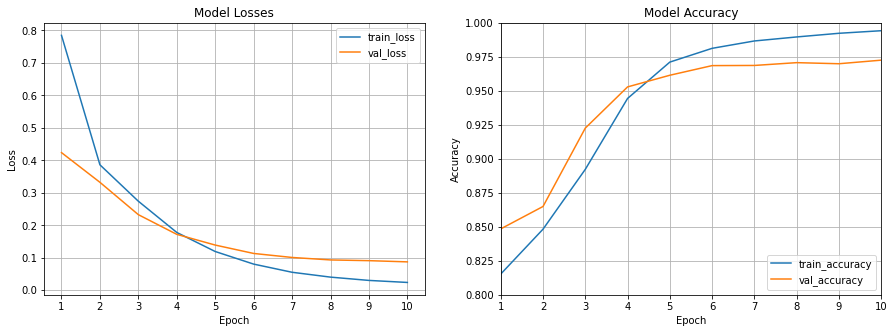

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xticks([0,1,2,3,4,5,6,7,8,9], labels = ['1','2','3','4','5','6','7','8','9','10'])
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.title('Model Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlim([0, 4])
plt.ylim([0.8, 1])
plt.xticks([0,1,2,3,4,5,6,7,8,9], labels = ['1','2','3','4','5','6','7','8','9','10'])
plt.legend(['train_accuracy', 'val_accuracy'], loc='lower right')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

In [72]:
# !pip install seqeval

In [285]:
idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out

test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

15/15 [==============================] - 1s 61ms/step


In [137]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [286]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 78.0%


In [287]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

              precision    recall  f1-score   support

     B-BRAND       0.76      0.91      0.83       620
   B-PRODUCT       0.94      0.86      0.90       621
     I-BRAND       0.92      0.75      0.83       418
   I-PRODUCT       0.00      0.00      0.00        40
           O       0.98      0.98      0.98      9226

    accuracy                           0.96     10925
   macro avg       0.72      0.70      0.71     10925
weighted avg       0.96      0.96      0.96     10925



In [288]:
input_word = Input(shape = (23,))
# print(input_word.shape)
model = Embedding(input_dim = no_of_words,
                  output_dim = 100,
                  input_length = 23)(input_word)
model = Bidirectional(LSTM(units=50,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(len_labels,
                            activation = 'sigmoid'))(model)
model = Model(input_word,out)
model.summary()

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = model.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 10,
    verbose =1
)

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_23 (Embedding)    (None, 23, 100)           406300    
                                                                 
 bidirectional_20 (Bidirecti  (None, 23, 100)          60400     
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 23, 5)            505       
 stributed)                                                      
                                                                 
Total params: 467,205
Trainable params: 467,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
48/48 [==============================] - 

In [2134]:
model.evaluate(X_test,np.array(y_test))

15/15 [==============================] - 1s 69ms/step - loss: 0.1043 - accuracy: 0.9643


[0.10427364706993103, 0.9643020629882812]

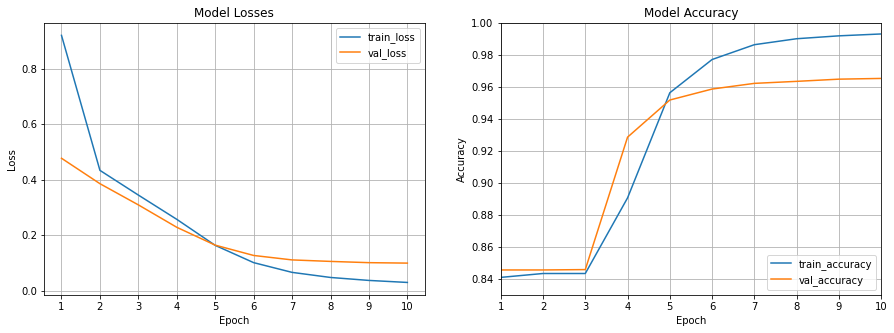

In [2136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xticks([0,1,2,3,4,5,6,7,8,9], labels = ['1','2','3','4','5','6','7','8','9','10'])
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.title('Model Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlim([0, 4])
plt.ylim([0.83, 1])
plt.xticks([0,1,2,3,4,5,6,7,8,9], labels = ['1','2','3','4','5','6','7','8','9','10'])
plt.legend(['train_accuracy', 'val_accuracy'], loc='lower right')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

# Experiments

In [289]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_1 = Embedding(input_dim = no_of_words,
                  output_dim = 50,
                  input_length = 23)(input_word)
bilstm_1 = Bidirectional(LSTM(units=25,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_1)
out = TimeDistributed(Dense(len_labels,
                            activation = 'sigmoid'))(bilstm_1)
bilstm_1 = Model(input_word,out)
bilstm_1.summary()

bilstm_1.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_1.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_1.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_1.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(flat_classification_report(y_pred=pred_labels, y_true=test_labels))

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_24 (Embedding)    (None, 23, 50)            203150    
                                                                 
 bidirectional_21 (Bidirecti  (None, 23, 50)           15200     
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 23, 5)            255       
 stributed)                                                      
                                                                 
Total params: 218,605
Trainable params: 218,605
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 1

In [290]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_2 = Embedding(input_dim = no_of_words,
                  output_dim = 50,
                  input_length = 23)(input_word)
bilstm_2 = Bidirectional(LSTM(units=25,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_2)
out = TimeDistributed(Dense(len_labels,
                            activation = 'softmax'))(bilstm_2)
bilstm_2 = Model(input_word,out)
bilstm_2.summary()

bilstm_2.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_2.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_2.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_2.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_25 (Embedding)    (None, 23, 50)            203150    
                                                                 
 bidirectional_22 (Bidirecti  (None, 23, 50)           15200     
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 23, 5)            255       
 stributed)                                                      
                                                                 
Total params: 218,605
Trainable params: 218,605
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 7

In [291]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_3 = Embedding(input_dim = no_of_words,
                  output_dim = 50,
                  input_length = 23)(input_word)
bilstm_3 = Bidirectional(LSTM(units=50,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_3)
out = TimeDistributed(Dense(len_labels,
                            activation = 'sigmoid'))(bilstm_3)
bilstm_3 = Model(input_word,out)
bilstm_3.summary()

bilstm_3.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_3.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_3.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_3.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_26 (Embedding)    (None, 23, 50)            203150    
                                                                 
 bidirectional_23 (Bidirecti  (None, 23, 100)          40400     
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 23, 5)            505       
 stributed)                                                      
                                                                 
Total params: 244,055
Trainable params: 244,055
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 1

In [292]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_4 = Embedding(input_dim = no_of_words,
                  output_dim = 50,
                  input_length = 23)(input_word)
bilstm_4 = Bidirectional(LSTM(units=50,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_4)
out = TimeDistributed(Dense(len_labels,
                            activation = 'softmax'))(bilstm_4)
bilstm_4 = Model(input_word,out)
bilstm_4.summary()

bilstm_4.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_4.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_4.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_4.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_27 (Embedding)    (None, 23, 50)            203150    
                                                                 
 bidirectional_24 (Bidirecti  (None, 23, 100)          40400     
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 23, 5)            505       
 stributed)                                                      
                                                                 
Total params: 244,055
Trainable params: 244,055
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 1

In [293]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_5 = Embedding(input_dim = no_of_words,
                  output_dim = 50,
                  input_length = 23)(input_word)
bilstm_5 = Bidirectional(LSTM(units=100,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_5)
out = TimeDistributed(Dense(len_labels,
                            activation = 'sigmoid'))(bilstm_5)
bilstm_5 = Model(input_word,out)
bilstm_5.summary()

bilstm_5.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_5.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_5.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_5.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_28 (Embedding)    (None, 23, 50)            203150    
                                                                 
 bidirectional_25 (Bidirecti  (None, 23, 200)          120800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 23, 5)            1005      
 stributed)                                                      
                                                                 
Total params: 324,955
Trainable params: 324,955
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 9

In [294]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_6 = Embedding(input_dim = no_of_words,
                  output_dim = 50,
                  input_length = 23)(input_word)
bilstm_6 = Bidirectional(LSTM(units=100,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_6)
out = TimeDistributed(Dense(len_labels,
                            activation = 'softmax'))(bilstm_6)
bilstm_6 = Model(input_word,out)
bilstm_6.summary()

bilstm_6.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_6.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_6.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_6.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_29 (Embedding)    (None, 23, 50)            203150    
                                                                 
 bidirectional_26 (Bidirecti  (None, 23, 200)          120800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 23, 5)            1005      
 stributed)                                                      
                                                                 
Total params: 324,955
Trainable params: 324,955
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 1

In [295]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_7 = Embedding(input_dim = no_of_words,
                  output_dim = 100,
                  input_length = 23)(input_word)
bilstm_7 = Bidirectional(LSTM(units=25,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_7)
out = TimeDistributed(Dense(len_labels,
                            activation = 'sigmoid'))(bilstm_7)
bilstm_7 = Model(input_word,out)
bilstm_7.summary()

bilstm_7.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_7.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_7.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_7.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_30 (Embedding)    (None, 23, 100)           406300    
                                                                 
 bidirectional_27 (Bidirecti  (None, 23, 50)           25200     
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 23, 5)            255       
 stributed)                                                      
                                                                 
Total params: 431,755
Trainable params: 431,755
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 9

In [296]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_8 = Embedding(input_dim = no_of_words,
                  output_dim = 100,
                  input_length = 23)(input_word)
bilstm_8 = Bidirectional(LSTM(units=25,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_8)
out = TimeDistributed(Dense(len_labels,
                            activation = 'softmax'))(bilstm_8)
bilstm_8 = Model(input_word,out)
bilstm_8.summary()

bilstm_8.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_8.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_8.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_8.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_31 (Embedding)    (None, 23, 100)           406300    
                                                                 
 bidirectional_28 (Bidirecti  (None, 23, 50)           25200     
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 23, 5)            255       
 stributed)                                                      
                                                                 
Total params: 431,755
Trainable params: 431,755
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 1

In [297]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_9 = Embedding(input_dim = no_of_words,
                  output_dim = 100,
                  input_length = 23)(input_word)
bilstm_9 = Bidirectional(LSTM(units=50,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_9)
out = TimeDistributed(Dense(len_labels,
                            activation = 'sigmoid'))(bilstm_9)
bilstm_9 = Model(input_word,out)
bilstm_9.summary()

bilstm_9.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_9.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_9.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_9.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_32 (Embedding)    (None, 23, 100)           406300    
                                                                 
 bidirectional_29 (Bidirecti  (None, 23, 100)          60400     
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 23, 5)            505       
 stributed)                                                      
                                                                 
Total params: 467,205
Trainable params: 467,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 1

In [298]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_10 = Embedding(input_dim = no_of_words,
                  output_dim = 100,
                  input_length = 23)(input_word)
bilstm_10 = Bidirectional(LSTM(units=50,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_10)
out = TimeDistributed(Dense(len_labels,
                            activation = 'softmax'))(bilstm_10)
bilstm_10 = Model(input_word,out)
bilstm_10.summary()

bilstm_10.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_10.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_10.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_10.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_33 (Embedding)    (None, 23, 100)           406300    
                                                                 
 bidirectional_30 (Bidirecti  (None, 23, 100)          60400     
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 23, 5)            505       
 stributed)                                                      
                                                                 
Total params: 467,205
Trainable params: 467,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 1

In [299]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_11 = Embedding(input_dim = no_of_words,
                  output_dim = 100,
                  input_length = 23)(input_word)
bilstm_11 = Bidirectional(LSTM(units=100,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_11)
out = TimeDistributed(Dense(len_labels,
                            activation = 'sigmoid'))(bilstm_11)
bilstm_11 = Model(input_word,out)
bilstm_11.summary()

bilstm_11.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_11.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_11.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_11.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_34 (Embedding)    (None, 23, 100)           406300    
                                                                 
 bidirectional_31 (Bidirecti  (None, 23, 200)          160800    
 onal)                                                           
                                                                 
 time_distributed_31 (TimeDi  (None, 23, 5)            1005      
 stributed)                                                      
                                                                 
Total params: 568,105
Trainable params: 568,105
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 1

In [300]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_12 = Embedding(input_dim = no_of_words,
                  output_dim = 100,
                  input_length = 23)(input_word)
bilstm_12 = Bidirectional(LSTM(units=100,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_12)
out = TimeDistributed(Dense(len_labels,
                            activation = 'softmax'))(bilstm_12)
bilstm_12 = Model(input_word,out)
bilstm_12.summary()

bilstm_12.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_12.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_12.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_12.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_35 (Embedding)    (None, 23, 100)           406300    
                                                                 
 bidirectional_32 (Bidirecti  (None, 23, 200)          160800    
 onal)                                                           
                                                                 
 time_distributed_32 (TimeDi  (None, 23, 5)            1005      
 stributed)                                                      
                                                                 
Total params: 568,105
Trainable params: 568,105
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 1

In [301]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_13 = Embedding(input_dim = no_of_words,
                  output_dim = 200,
                  input_length = 23)(input_word)
bilstm_13 = Bidirectional(LSTM(units=25,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_13)
out = TimeDistributed(Dense(len_labels,
                            activation = 'sigmoid'))(bilstm_13)
bilstm_13 = Model(input_word,out)
bilstm_13.summary()

bilstm_13.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_13.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_13.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_13.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_36 (Embedding)    (None, 23, 200)           812600    
                                                                 
 bidirectional_33 (Bidirecti  (None, 23, 50)           45200     
 onal)                                                           
                                                                 
 time_distributed_33 (TimeDi  (None, 23, 5)            255       
 stributed)                                                      
                                                                 
Total params: 858,055
Trainable params: 858,055
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 7

# Best BiLSTM model

In [139]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_14 = Embedding(input_dim = no_of_words,
                  output_dim = 200,
                  input_length = 23)(input_word)
bilstm_14 = Bidirectional(LSTM(units=25,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_14)
out = TimeDistributed(Dense(len_labels,
                            activation = 'softmax'))(bilstm_14)
bilstm_14 = Model(input_word,out)
bilstm_14.summary()

bilstm_14.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_14.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 10,
    verbose =1
)

print(bilstm_14.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out

test_pred = bilstm_14.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

# import matplotlib.pyplot as plt

# plt.figure(figsize=(15,5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='train_loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.xticks([0,1,2,3,4,5,6,7,8,9], labels = ['1','2','3','4','5','6','7','8','9','10'])
# plt.legend(['train_loss', 'val_loss'], loc='upper right')
# plt.title('Model Losses')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.grid()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='train_accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')
# plt.xlim([0, 4])
# plt.ylim([0.8, 1])
# plt.xticks([0,1,2,3,4,5,6,7,8,9], labels = ['1','2','3','4','5','6','7','8','9','10'])
# plt.legend(['train_accuracy', 'val_accuracy'], loc='lower right')
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.grid()
# plt.show()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 23)]              0         
                                                                 
 embedding_8 (Embedding)     (None, 23, 200)           812600    
                                                                 
 bidirectional_2 (Bidirectio  (None, 23, 50)           45200     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 23, 5)            255       
 tributed)                                                       
                                                                 
Total params: 858,055
Trainable params: 858,055
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
48/48 [==============================] - 4

In [423]:
# pred_labels

In [424]:
# test_labels

### Wrong Tag error analysis

In [140]:
wrong_tag = 0
for gold, pred in zip(test_labels, pred_labels):
    for i in range(len(gold)):
#         print(gold[2])
#         print(pred[2])
        if (gold[i]==pred[i])== False:
            wrong_tag += 1

print(wrong_tag)

336


In [141]:
ypred = list()
for item in pred_labels:
    for tok in item: 
        ypred.append(tok)

In [142]:
len(ypred)

10925

In [144]:
wrong_tag/len(ypred)

0.030755148741418763

### No annotation error analysis

In [145]:
total = 0
for pred in pred_labels:
#     print(pred)
    for i in range(len(pred)):
#         print(pred[i])
#         if (str(pred[i]) in tags):
#             total =+ 1
        if (pred[i]=='B-BRAND' or pred[i]=='I-BRAND' or pred[i]=='B-PRODUCT' or pred[i]=='I-PRODUCT'):
            total +=1

print(total)

1747


In [146]:
no_annot = 0
for gold, pred in zip(test_labels, pred_labels):
    for i in range(len(gold)):
#         print(gold[2])
#         print(pred[2])
        if gold[i]=='B-BRAND':
            if pred[i]=="O":
                no_annot += 1
        if gold[i]=='B-PRODUCT':
            if pred[i]=="O":
                no_annot += 1
        if gold[i]=='I-BRAND':
            if pred[i]=="O":
                no_annot += 1
        if gold[i]=='I-PRODUCT':
            if pred[i]=="O":
                no_annot += 1
                
print(no_annot)

123


In [147]:
no_annot/total

0.07040641099026904

In [303]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_15 = Embedding(input_dim = no_of_words,
                  output_dim = 200,
                  input_length = 23)(input_word)
bilstm_15 = Bidirectional(LSTM(units=50,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_15)
out = TimeDistributed(Dense(len_labels,
                            activation = 'sigmoid'))(bilstm_15)
bilstm_15 = Model(input_word,out)
bilstm_15.summary()

bilstm_15.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_15.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_15.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_15.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_38 (Embedding)    (None, 23, 200)           812600    
                                                                 
 bidirectional_35 (Bidirecti  (None, 23, 100)          100400    
 onal)                                                           
                                                                 
 time_distributed_35 (TimeDi  (None, 23, 5)            505       
 stributed)                                                      
                                                                 
Total params: 913,505
Trainable params: 913,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 1

In [304]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_16 = Embedding(input_dim = no_of_words,
                  output_dim = 200,
                  input_length = 23)(input_word)
bilstm_16 = Bidirectional(LSTM(units=50,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_16)
out = TimeDistributed(Dense(len_labels,
                            activation = 'softmax'))(bilstm_16)
bilstm_16 = Model(input_word,out)
bilstm_16.summary()

bilstm_16.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_16.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_16.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_16.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_39 (Embedding)    (None, 23, 200)           812600    
                                                                 
 bidirectional_36 (Bidirecti  (None, 23, 100)          100400    
 onal)                                                           
                                                                 
 time_distributed_36 (TimeDi  (None, 23, 5)            505       
 stributed)                                                      
                                                                 
Total params: 913,505
Trainable params: 913,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================] - 1

In [305]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_17 = Embedding(input_dim = no_of_words,
                  output_dim = 200,
                  input_length = 23)(input_word)
bilstm_17 = Bidirectional(LSTM(units=100,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_17)
out = TimeDistributed(Dense(len_labels,
                            activation = 'sigmoid'))(bilstm_17)
bilstm_17 = Model(input_word,out)
bilstm_17.summary()

bilstm_17.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_17.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_17.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_17.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_40 (Embedding)    (None, 23, 200)           812600    
                                                                 
 bidirectional_37 (Bidirecti  (None, 23, 200)          240800    
 onal)                                                           
                                                                 
 time_distributed_37 (TimeDi  (None, 23, 5)            1005      
 stributed)                                                      
                                                                 
Total params: 1,054,405
Trainable params: 1,054,405
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================]

In [306]:
input_word = Input(shape = (23,))
# print(input_word.shape)
bilstm_18 = Embedding(input_dim = no_of_words,
                  output_dim = 200,
                  input_length = 23)(input_word)
bilstm_18 = Bidirectional(LSTM(units=100,
                           return_sequences = True, 
                           recurrent_dropout = 0.1))(bilstm_18)
out = TimeDistributed(Dense(len_labels,
                            activation = 'softmax'))(bilstm_18)
bilstm_18 = Model(input_word,out)
bilstm_18.summary()

bilstm_18.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

history = bilstm_18.fit(
    X_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose =1
)

print(bilstm_18.evaluate(X_test,np.array(y_test)))

idx2tag = {i: w for w, i in label2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out
test_pred = bilstm_18.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 23)]              0         
                                                                 
 embedding_41 (Embedding)    (None, 23, 200)           812600    
                                                                 
 bidirectional_38 (Bidirecti  (None, 23, 200)          240800    
 onal)                                                           
                                                                 
 time_distributed_38 (TimeDi  (None, 23, 5)            1005      
 stributed)                                                      
                                                                 
Total params: 1,054,405
Trainable params: 1,054,405
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
48/48 [==============================]